<a href="https://colab.research.google.com/github/lorenzo-stacchio/Fashion-in-The-Metaverse-Tutorial/blob/main/Artificial%20Intelligence/Fashion_in_the_Metaverse_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [24]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [25]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

### Download SAM weights

In [26]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [27]:
import os
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [28]:
!mkdir -p {HOME}/data

!wget -q https://github.com/lorenzo-stacchio/Fashion-in-The-Metaverse-Tutorial/blob/main/Artificial%20Intelligence/test_images/Mixblu1_1024x1024.png?raw=true -P {HOME}/data

## Load Model

In [29]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [30]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [70]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [92]:
import os

IMAGE_NAME = "Mixblu1_1024x1024.png?raw=true"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Generate masks with SAM

In [93]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)

# Use this if the original image has different size w.r.t the generated ones!
# image_bgr = cv2.resize(image_bgr, (512,512), interpolation = cv2.INTER_AREA)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [94]:
mask_predictor = SamPredictor(sam)

In [95]:
import os

IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [96]:
# helper function that loads an image before adding it to the widget
import base64

def encode_image(cv2_image):
    # with open(filepath, 'rb') as f:
    #     image_bytes = f.read()
    retval, buffer = cv2.imencode('.png', cv2_image)
    base64_encoded = base64.b64encode(buffer)
    encoded = str(base64_encoded, 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [100]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
# widget.image = encode_image(IMAGE_PATH)
widget.image = encode_image(image_bgr)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [101]:
widget.bboxes

[{'x': 147, 'y': 341, 'width': 704, 'height': 532, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [102]:
import numpy as np

box = widget.bboxes[0]

box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [103]:
import cv2
import numpy as np
import supervision as sv

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

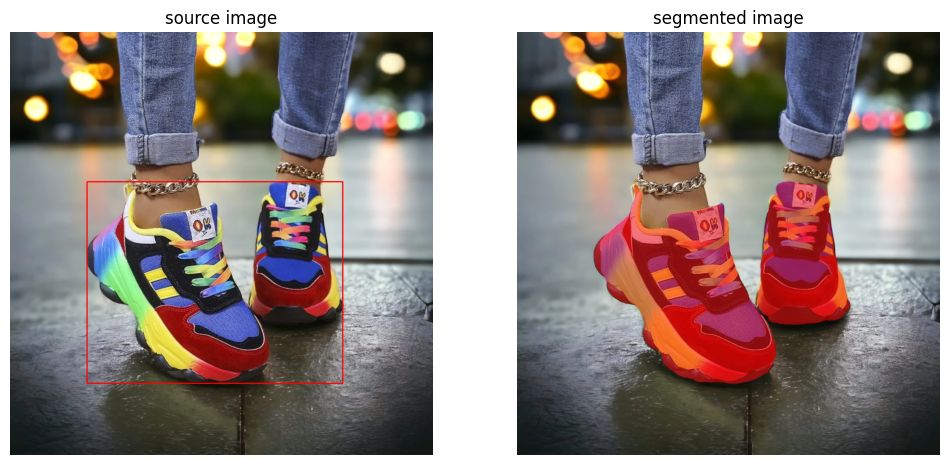

In [104]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [105]:
print(detections.mask)
%matplotlib inline
from PIL import Image
import numpy as np

data = detections.mask # red patch in upper left
data = data.squeeze().astype('uint8')*255

img = Image.fromarray(data)
img.save('mask.png')
img.show()

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


## Mask composition with generated ones

In [106]:
generated_folder = "/content/generated/"

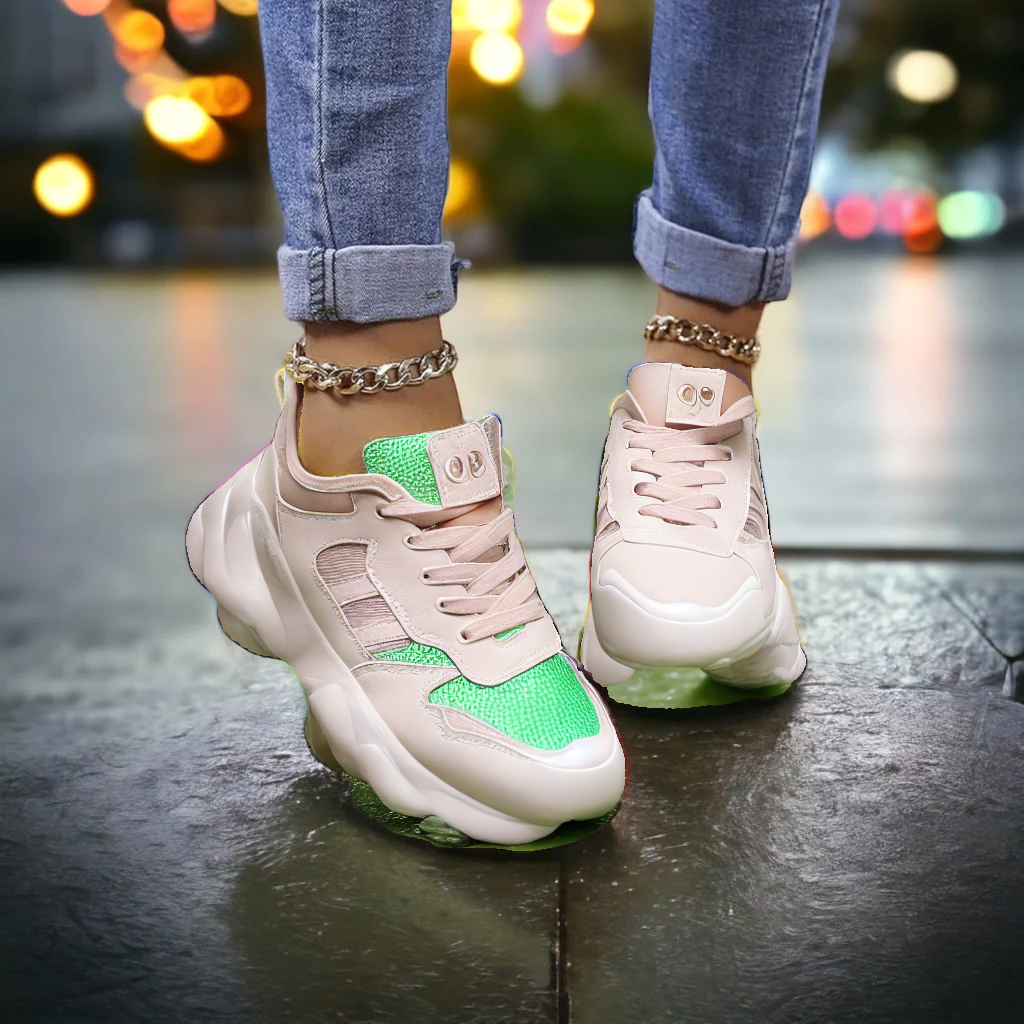

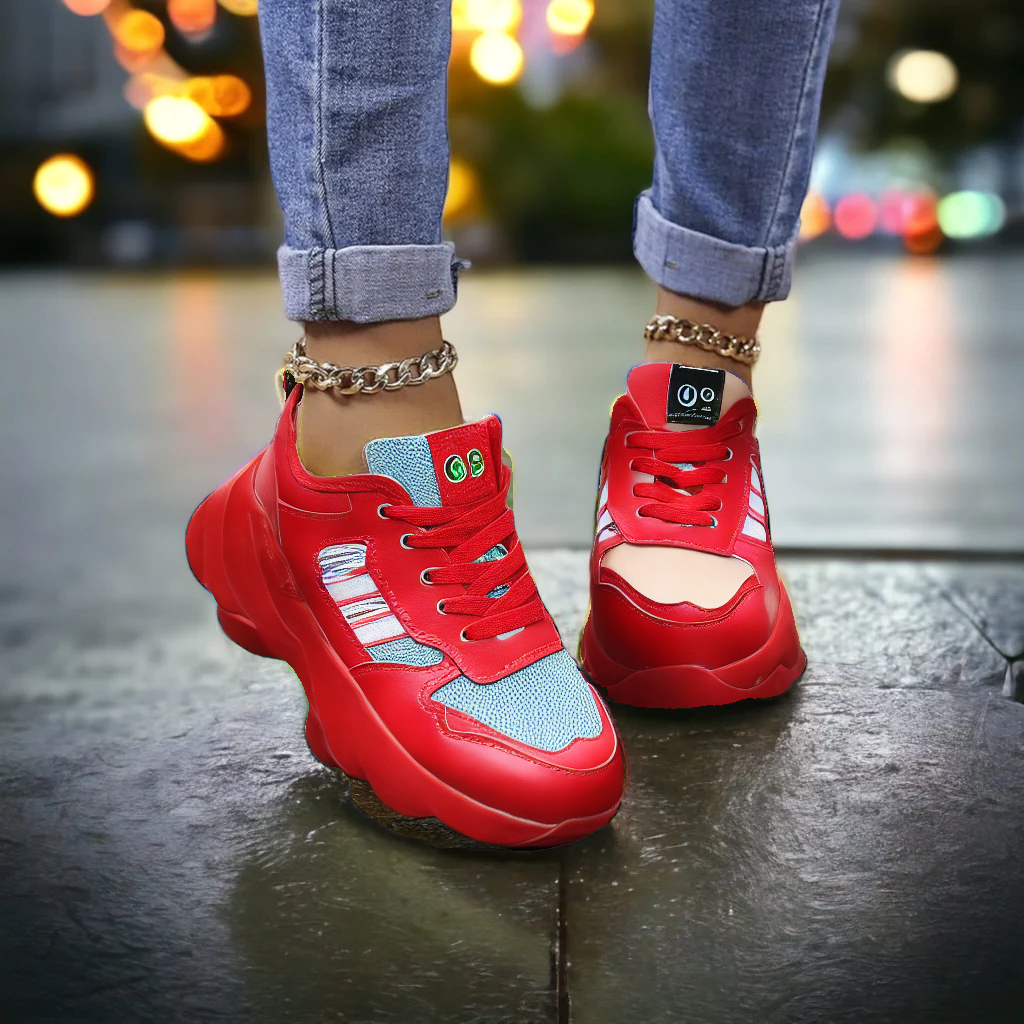

In [114]:
import glob

original_image =  cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

for idx, image_path in enumerate(glob.glob(generated_folder + "*")):
    generated_image = Image.open(image_path)

    binary_mask = Image.open('mask.png')  # Replace 'binary_mask.png' with your mask filename

    # Convert the images to NumPy arrays for easier manipulation
    original_array = np.array(original_image)
    generated_array = np.array(generated_image)
    mask_array = np.array(binary_mask)

    # Invert the mask (if needed) - assuming the mask is white (255) for the regions to be subtracted
    inverted_mask = 255 - mask_array

    # Subtract the mask from the original image
    result_array = original_array * (inverted_mask // 255)[:, :, None]

    result_array = result_array  + generated_image * (mask_array // 255)[:, :, None]

    # Convert the resulting array back to an image
    result_image = Image.fromarray(result_array.astype('uint8'))
    result_image.save(f"test_{idx}.png")
    display(result_image)
